In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.integrate import quad

In [ ]:
def make_histogram(data, bins=None, density=True):
    if bins is None:
        bins=int(data.size/2)
    return np.histogram(data, bins=bins,density=density)

def get_bin_centers(bin_edges):
    return (bin_edges[:-1]+bin_edges[1:])/2

def hist_scale_factor(data,bins):
    return ((data.max()-data.min())/bins)

def get_peak_estimates(data, bins=None, min_dist_Da=50, height=20, smooth=1):
    counts, bin_edges=make_histogram(data,bins,density=False)
    bin_center=get_bin_centers(bin_edges)
    min_dist=max(1,min_dist_Da/hist_scale_factor(data,counts.size))
    smoothed_counts=gaussian_filter1d(counts,smooth)
    peaks,properties=find_peaks(smoothed_counts, distance=min_dist,threshold=0,width=1,height=height)
    counts_dens, bin_edges=make_histogram(data,bins,density=True)
    
    est_A=counts[peaks]
    est_mu= bin_center[peaks]
    est_sig=bin_center[properties["right_ips"].astype("int")]-bin_center[properties["left_ips"].astype("int")]

    return np.array((est_A, est_mu, est_sig)).T,properties

def generate_bounds(peak_estimate):

    bound_ar=np.zeros((*peak_estimate.shape,2))
    for i in range(0, peak_estimate.shape[1]):
        bound_ar[0,i,:]=np.array((0,peak_estimate[0,i]+peak_estimate[0,i]*0.2))
        bound_ar[1,i,:]=np.array((peak_estimate[1,i]-peak_estimate[2,i],peak_estimate[1,i]+peak_estimate[2,i]))
        bound_ar[2,i,:]=np.array((0,peak_estimate[2,i]))
    
    return bound_ar.reshape(-1,bound_ar.shape[2],order="F")

def gauss(x,A,mu,sig):
    return A * np.exp(-((x - mu) ** 2) / (2 * sig ** 2))

def auc_gaussian_fwhm(amplitude, mean, sigma):
    # FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma
    # Integration limits (mean ± FWHM/2)
    x_min = mean - fwhm / 2
    x_max = mean + fwhm / 2
    # Define the Gaussian function
    def gaussian(x):
        return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2))
    # Integrate the Gaussian over the FWHM
    auc, _ = quad(gaussian, x_min, x_max)
    return auc

In [ ]:
# Load data and remove negative values

data_in=r"C:\Users\chem-chem1918\OneDrive\Documents\2_Master\5_Labrotations\AK-Rauschenbach\Data\Proteasome\20241219_XL-PA28ab_MP\001_20241219_120_XL-PA28ab_navg15.csv"

df=pd.read_csv(data_in,comment='#')
data=df[df["calibrated_values"]>0]["calibrated_values"].sort_values(ascending=True).to_numpy()

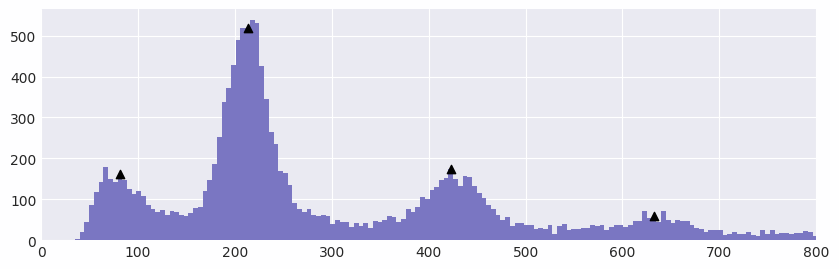

In [ ]:
# Get a first estimate of the peaks by using a simple peak finding algorithm

bins=2000
threshold=40
peak_est,properties=get_peak_estimates(
    data=data,
    bins=bins,
    min_dist_Da=20,
    height=threshold,
    smooth=5
    )

bounds=generate_bounds(peak_estimate=peak_est.T)
fig,ax=plt.subplots(figsize=(10,3))
ax.hist(data,bins=bins)
N=peak_est.size //3
ax.scatter(peak_est.T[1],peak_est.T[0],marker="^",color="k")
ax.set(xlim=(0,800));

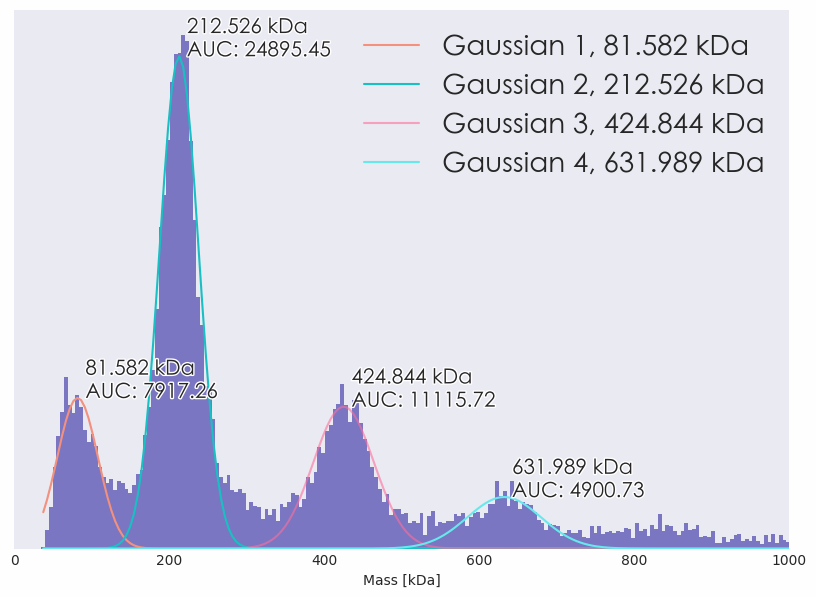

In [ ]:
# Plot the histogram, fit gaussians to the histogram by considering he fwhm of the peaks

counts, bin_edges = make_histogram(data,bins=bins,density=False)
bin_centers = get_bin_centers(bin_edges=bin_edges)
histo=np.array((bin_centers,counts)).T

fig,ax=plt.subplots(figsize=(10,7))
ax.hist(data,bins=bins)

gaussians=np.array([])
for i, est in enumerate(peak_est):
    peak=histo[(histo[:,0]>est[1]-est[2]) & (histo[:,0]<est[1]+est[2])]
    popt,pcov=curve_fit(gauss,peak[:,0],peak[:,1],p0=est)
    auc=auc_gaussian_fwhm(*popt)
    gaussians=np.append(gaussians,popt)
    ax.plot(histo[:,0],gauss(histo[:,0],*popt),label=f"Gaussian {i + 1}, {popt[1]:.3f} kDa")
    ax.text(popt[1]+10,popt[0],f"{popt[1]:.3f} kDa\nAUC: {auc:.2f}",size=15,fontfamily="Century Gothic",path_effects=[pe.withStroke(linewidth=2, foreground="white")],verticalalignment="baseline",clip_on=True)

ax.legend(prop={"family":"Century Gothic","size":20})
ax.set(xlim=(0,1000),xlabel="Mass [kDa]",ylabel="Counts")
ax.get_yaxis().set_visible(False)
ax.grid(False)
fig.savefig(r"path-to-save\fit_mp_data.svg")